### Optional: consider removing cloud-masked training samples, especially from the positive training dataset

A few partly-masked images in the negative dataset is probably healthy

In [12]:
from datetime import date
import glob
import os
import random
import shutil
import sys

import matplotlib.pyplot as plt
import numpy as np
import rasterio

parent_dir = os.path.split(os.getcwd())[0]
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

from scripts import viz_tools

WORK_DIR = '../data/training_patches2025-08-27/'

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
def read_tif(path):
    with rasterio.open(path) as f:
        img = f.read()
    img = np.moveaxis(img, 0, -1)
    return img.astype('float32')

positive_paths = glob.glob(f"{WORK_DIR}/train/1/*.tif")
positive_patches = np.array([read_tif(p) for p in positive_paths])
negative_paths = glob.glob(f"{WORK_DIR}/train/0/*.tif")
negative_patches = np.array([read_tif(p) for p in negative_paths])

print(len(positive_patches), "positive samples loaded")
print(len(negative_patches), "negative samples loaded")

2522 positive samples loaded
22813 negative samples loaded


In [ ]:
def filter_black(data, mask_limit=0.1, dark_level=10):
    masked_fraction = np.array([np.sum(np.mean(patch[:,:,1:2], axis=-1) < dark_level) / np.size(np.mean(patch[:,:,1:2], axis=-1)) for patch in data])
    filtered_data = data[masked_fraction <= mask_limit]
    print(f"{len(filtered_data) / len(data) :.4%} of data passes filter")

    rejected_indices = np.where(masked_fraction > mask_limit)[0]
    rejected_data = data[rejected_indices]
    return filtered_data, rejected_data, rejected_indices


In [11]:
# Filter pixels that are masked beyond a threshold. We want to avoid giving positive examples of cloud-masked patches
filtered, rejects, rejected_indices = filter_black(positive_patches, mask_limit = 0)

if len(rejects) > 0:
    num_samples = min(len(rejects), 256)
    rgbs = rejects[:,:,:,3:0:-1] / 3000
    viz_samples = random.sample(list(rgbs), num_samples)
    viz_tools.plot_numpy_grid(viz_samples)
    plt.title("Masked Rejects")

100.0000% of data passes filter


In [ ]:
for src in np.array(positive_paths)[rejected_indices]:
    dest_dir = os.path.join(os.path.dirname(src), 'cloud_mask_rejects')
    os.makedirs(dest_dir, exist_ok=True)
    dest = os.path.join(dest_dir, os.path.basename(src))
    shutil.move(src, dest)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.6779999732971191].


99.7764% of data passes filter


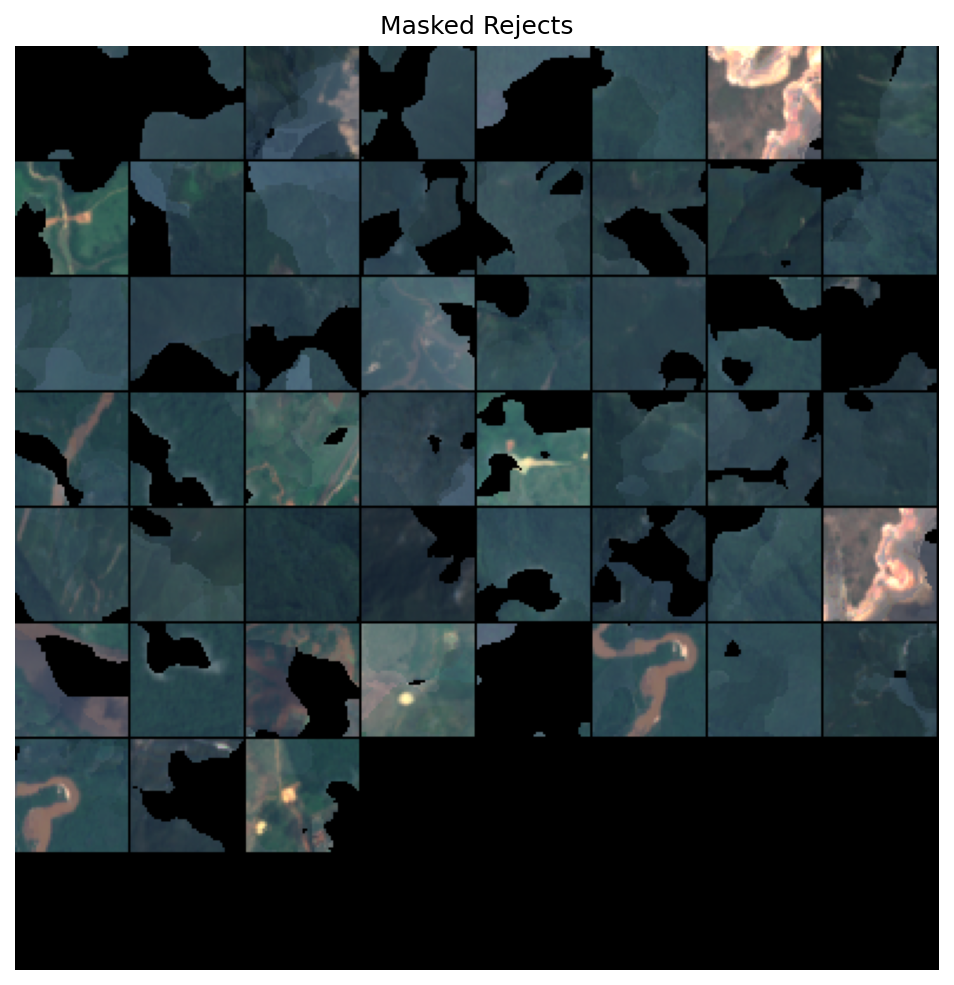

In [14]:
# Filter pixels that are masked beyond a threshold. 
filtered, rejects, rejected_indices = filter_black(negative_patches, mask_limit = 0)

if len(rejects) > 0:
    num_samples = min(len(rejects), 256)
    rgbs = rejects[:,:,:,3:0:-1] / 3000
    viz_samples = random.sample(list(rgbs), num_samples)
    viz_tools.plot_numpy_grid(viz_samples)
    plt.title("Masked Rejects")

In [ ]:
num_samples = 16 ** 2
indices = np.random.randint(0, len(filtered), num_samples)
fig = viz_tools.plot_numpy_grid(filtered[indices,:,:,3:0:-1] / 3000)
plt.title('Filtered Samples')
plt.show()

In [ ]:
cloudy = np.array(negative_paths)[rejected_indices]
random.shuffle(cloudy)
print(len(cloudy))

In [ ]:
n_to_remove = 0
for src in cloudy[:n_to_remove]:
    dest_dir = os.path.join(os.path.dirname(src), 'cloud_mask_rejects')
    os.makedirs(dest_dir, exist_ok=True)
    dest = os.path.join(dest_dir, os.path.basename(src))
    shutil.move(src, dest)